In [32]:
import json
import os

import pandas as pd
import numpy as np

def read_json_to_df(file_name):
    data = []
    with open(file_name) as data_file:
        for line in data_file:
            # Load each line of the JSON file as a dictionary
            data.append(json.loads(line))

    # Form a Pandas DataFrame from the dictionaries
    return pd.json_normalize(data)

# Load the training and test data
raw_train_df = read_json_to_df("hotel_reviews_train.json")
raw_test_df = read_json_to_df("hotel_reviews_test.json")

ratings_columns = [col for col in raw_train_df.columns if col.startswith("ratings.")]

# Select the title, text and overall rating columns to make a new dataframe
train_df = raw_train_df[["title", "text"] + ratings_columns]
test_df = raw_test_df[["title", "text"] + ratings_columns]

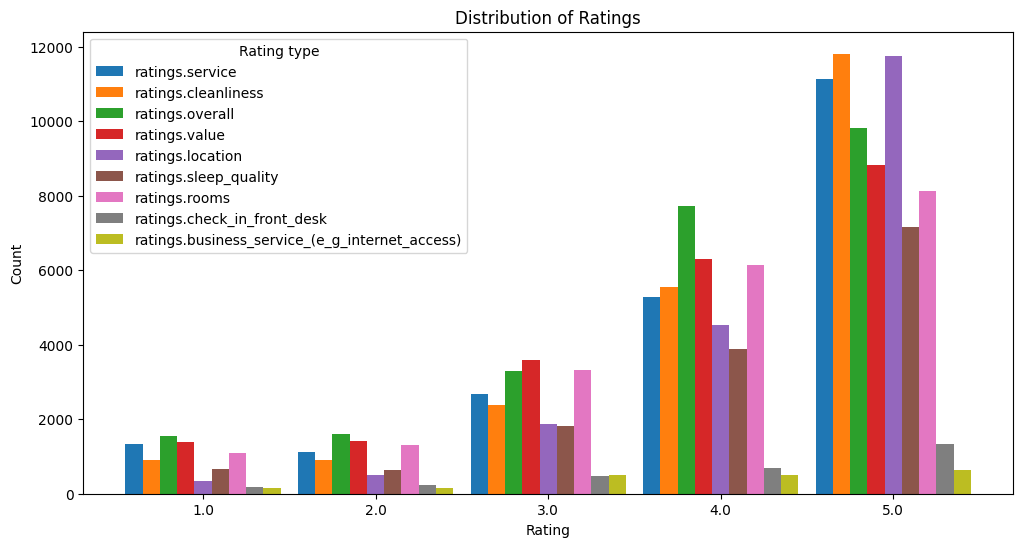

In [33]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))

rating_counts = pd.DataFrame({
    col: train_df[col].value_counts().sort_index() for col in ratings_columns
})

bar_width = 0.15
group_spacing = 1.5
indices = np.arange(len(rating_counts)) * group_spacing

for i, column in enumerate(rating_counts.columns):
    plt.bar(indices + i * bar_width, rating_counts[column], width=bar_width, label=column)

plt.xticks(indices + bar_width * (len(ratings_columns) - 1) / 2, rating_counts.index)

plt.xlabel("Rating")
plt.ylabel("Count")
plt.title("Distribution of Ratings")
plt.legend(title="Rating type")
plt.show()

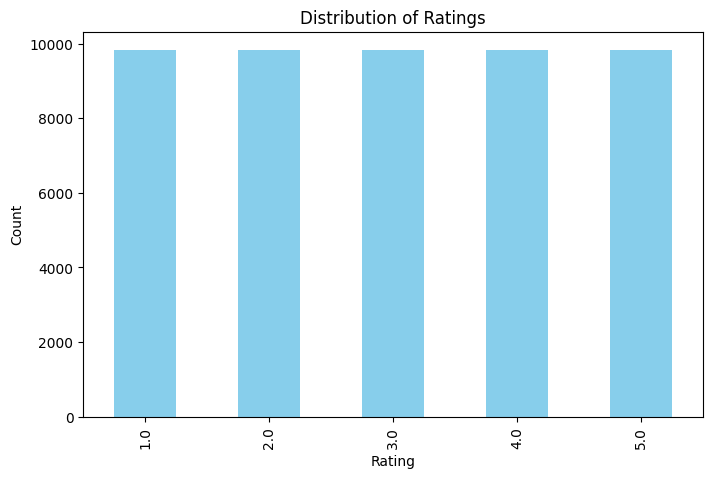

In [34]:
# Balance the training data by oversampling
def balance_data_oversample(df):
    max_count = df['ratings.overall'].value_counts().max()
    balanced_df = pd.DataFrame()

    for rating in df['ratings.overall'].unique():
        rating_df = df[df['ratings.overall'] == rating]
        balanced_df = pd.concat([balanced_df, rating_df.sample(max_count, replace=True)])

    return balanced_df
balanced_train_df = balance_data_oversample(train_df)

# Plot distribution of ratings
balanced_train_df['ratings.overall'].value_counts().sort_index().plot(kind='bar', figsize=(8,5), color='skyblue')

plt.xlabel("Rating")
plt.ylabel("Count")
plt.title("Distribution of Ratings")
plt.show()

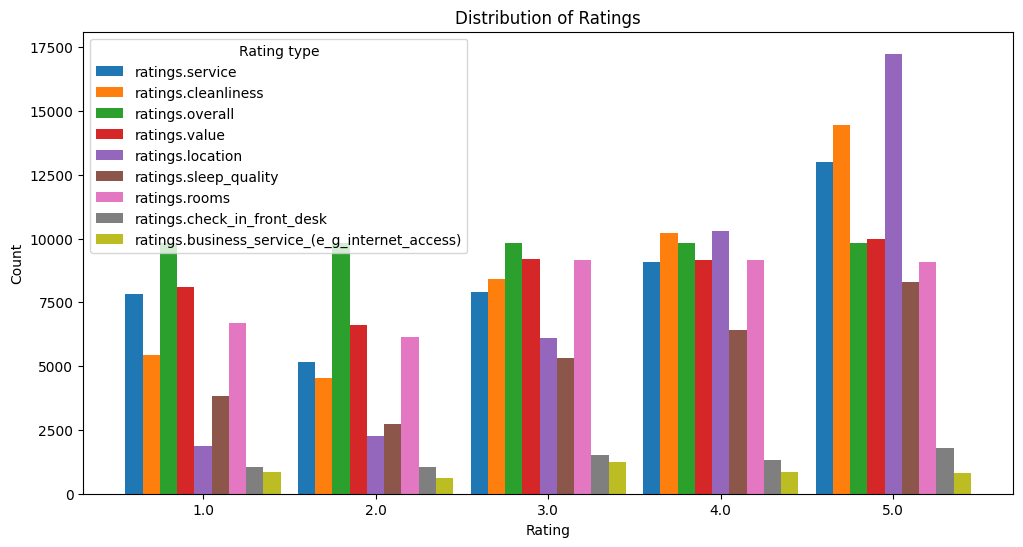

In [35]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))

rating_counts = pd.DataFrame({
    col: balanced_train_df[col].value_counts().sort_index() for col in ratings_columns
})

bar_width = 0.15
group_spacing = 1.5
indices = np.arange(len(rating_counts)) * group_spacing

for i, column in enumerate(rating_counts.columns):
    plt.bar(indices + i * bar_width, rating_counts[column], width=bar_width, label=column)

plt.xticks(indices + bar_width * (len(ratings_columns) - 1) / 2, rating_counts.index)

plt.xlabel("Rating")
plt.ylabel("Count")
plt.title("Distribution of Ratings")
plt.legend(title="Rating type")
plt.show()

In [36]:
balanced_train_df.fillna(0)

,title,text,ratings.service,ratings.cleanliness,ratings.overall,ratings.value,ratings.location,ratings.sleep_quality,ratings.rooms,ratings.check_in_front_desk,ratings.business_service_(e_g_internet_access)
17641,"“Disappointing, even at a 50% discount”",Our party had one couple and another couple wi...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
22357,“They overcharged us and refused to correct it...,We stayed at the hotel for 4 nights. My husban...,3.0,3.0,1.0,1.0,5.0,0.0,4.0,0.0,0.0
13649,“They Steal Credit Card Number & Identification”,I stayed at this place when it was named the E...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
19928,“Not for the business traveler - awful amenities”,This hotel advertises itself as a business / c...,4.0,3.0,1.0,1.0,4.0,2.0,3.0,0.0,0.0
17716,“Nasty”,Don't go to this hotel unless you like nasty h...,2.0,1.0,1.0,1.0,3.0,0.0,1.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...
5225,“Great Hotel”,I stayed there for a week and it became my fav...,5.0,4.0,5.0,4.0,5.0,4.0,5.0,0.0,0.0
18632,“Simply outstanding.”,A great hotel with a perfect location. Staff w...,5.0,5.0,5.0,5.0,0.0,0.0,5.0,0.0,0.0
11001,“A great place to stay”,Our family has stayed at the Aloft twice and b...,5.0,5.0,5.0,5.0,0.0,5.0,0.0,0.0,0.0
7505,"“Great location, cool building, pleasant and r...",We stayed in a tower suite and had iconic view...,5.0,5.0,5.0,4.0,5.0,0.0,4.0,0.0,0.0


In [37]:
inputs = balanced_train_df[ratings_columns]
outputs = balanced_train_df['text']

inputs_test = test_df[ratings_columns]
outputs_test = test_df['text']

In [38]:
def format_input(rating) -> str:
    input = "Generate a hotel review based on the following ratings:\n"
    service = rating.iloc[0]
    cleanliness = rating.iloc[1]
    overall = rating.iloc[2]
    value = rating.iloc[3]
    location = rating.iloc[4]
    sleep_quality = rating.iloc[5]
    rooms = rating.iloc[6]
    check_in_front_desk = rating.iloc[7]
    business_service = rating.iloc[8]

    if service != 0:
      input += f"- service: {service}\n"
    if cleanliness != 0:
      input += f"- cleanliness: {cleanliness}\n"
    if overall != 0:
      input += f"- overall: {overall}\n"
    if value != 0:
      input += f"- value: {value}\n"
    if location != 0:
      input += f"- location: {location}\n"
    if sleep_quality != 0:
      input += f"- sleep quality: {sleep_quality}\n"
    if rooms != 0:
      input += f"- rooms: {rooms}\n"
    if check_in_front_desk != 0:
      input += f"- check in: {check_in_front_desk}\n"
    if business_service != 0:
      input += f"- business service: {business_service}\n"

    input += "Review: "

    return input

In [40]:
from transformers import T5Tokenizer, T5ForConditionalGeneration, Trainer, TrainingArguments

from datasets import Dataset

dataset = Dataset.from_dict({"ratings": inputs.apply(format_input, axis=1).to_list(), "review_text": outputs.to_list()})

dataset = dataset.shuffle()
dataset = dataset.select(range(1000))

# Preprocessing function for dataset
def preprocess(examples):
    model_inputs = tokenizer(examples["ratings"], truncation=True, padding="max_length", max_length=128)
    labels = tokenizer(examples["review_text"], truncation=True, padding="max_length", max_length=512)
    model_inputs["labels"] = labels["input_ids"]
    return model_inputs

tokenizer = T5Tokenizer.from_pretrained('t5-small')
model = T5ForConditionalGeneration.from_pretrained('t5-small')

tokenized = dataset.map(preprocess, batched=True)
training_args = TrainingArguments(output_dir='./results', per_device_train_batch_size=4, num_train_epochs=10)

trainer = Trainer(model=model, args=training_args, train_dataset=tokenized)
trainer.train()

Map:   0%|          | 0/1000 [00:00<?, ? examples/s]

Step,Training Loss
500,1.998400
1000,1.659200
1500,1.636400
2000,1.623800
2500,1.617200


TrainOutput(global_step=2500, training_loss=1.706978369140625, metrics={'train_runtime': 604.0825, 'train_samples_per_second': 16.554, 'train_steps_per_second': 4.139, 'total_flos': 338354503680000.0, 'train_loss': 1.706978369140625, 'epoch': 10.0})

In [41]:
def generate_review(ratings_str):
    device = model.device
    inputs = tokenizer(ratings_str, return_tensors="pt").to(device)
    output = model.generate(**inputs, max_length=512)
    return tokenizer.decode(output[0], skip_special_tokens=True)


test_dataset = Dataset.from_dict({"ratings": inputs_test.apply(format_input, axis=1).to_list(), "review_text": outputs_test.to_list()})

test_dataset = test_dataset.select(range(100))  # Select first 100 rows

from rouge import Rouge
rouge = Rouge()

# Example
for example in test_dataset:
    generated_review = generate_review(example["ratings"])

    print("Input:", example["ratings"])
    print("Generated review:", generated_review)
    print("Actual review:", example["review_text"])
    # Evaluate the summaries using the ROUGE metric
    scores_abstractive = rouge.get_scores(generated_review, example["review_text"])

    # Print the summaries and ROUGE scores
    print("ROUGE Scores for Abstractive Summary: ", scores_abstractive)
    print('\n')

Input: Generate a hotel review based on the following ratings:
- service: 5.0
- cleanliness: 5.0
- overall: 5.0
- value: 5.0
- location: 5.0
- sleep quality: 5.0
- rooms: 5.0
- check in: nan
- business service: nan
Review: 
Generated review: The hotel is a great location for a shopping trip. The staff is very helpful and helpful. The location is great, but the staff is very friendly and helpful. The hotel is very close to the city center and the city center. The room is very nice and the staff is very friendly. The location is great. The staff are very friendly and the staff are very helpful. The hotel is very close to the city center. The hotel is very close to the city center. The hotel is very quiet and the hotel is very close to the city center. The hotel is a great location. The hotel is a bit of the city. The location is very good. The hotel is a great location. The hotel is very clean and the hotel is very nice. The hotel is very close to the city center and the city center. The

In [42]:
from bert_score import score
from rouge import Rouge
from tqdm import tqdm 

rouge = Rouge()

generated_texts = []
reference_texts = []

# Iterate through the dataset
for example in tqdm(test_dataset):
    generated_review = generate_review(example["ratings"])
    reference_review = example["review_text"]

    generated_texts.append(generated_review)
    reference_texts.append(reference_review)

# Compute average ROUGE scores over all examples
scores = rouge.get_scores(generated_texts, reference_texts, avg=True)

# Print nicely formatted scores
print("=== AVERAGE ROUGE SCORES ===")
for metric, sub_scores in scores.items():
    print(f"{metric.upper()}:")
    for sub_metric, value in sub_scores.items():
        print(f"  {sub_metric}: {value:.4f}")

P, R, F1 = score(generated_texts, reference_texts, lang="en", verbose=True)

# Print average scores
print("=== BERTScore Results ===")
print(f"Precision: {P.mean().item():.4f}")
print(f"Recall:    {R.mean().item():.4f}")
print(f"F1 Score:  {F1.mean().item():.4f}")

100%|██████████| 100/100 [01:38<00:00,  1.02it/s]


=== AVERAGE ROUGE SCORES ===
ROUGE-1:
  r: 0.1793
  p: 0.3897
  f: 0.2242
ROUGE-2:
  r: 0.0497
  p: 0.0822
  f: 0.0536
ROUGE-L:
  r: 0.1700
  p: 0.3709
  f: 0.2128


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


calculating scores...
computing bert embedding.


  0%|          | 0/4 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/2 [00:00<?, ?it/s]

done in 8.78 seconds, 11.39 sentences/sec
=== BERTScore Results ===
Precision: 0.8234
Recall:    0.8214
F1 Score:  0.8219


In [45]:
generated_review = generate_review("""Input: Generate a hotel review based on the following ratings:
- cleanliness: 1.0
Review: 
""")
print(generated_review)

I was able to stay at the Hilton again and I was very happy with the reviews. I have stayed at the Hilton for a few nights. I was a bit disappointed with the hotel's cleanliness. I was disappointed with the fact that the hotel was so good. I was very impressed with the hotel's cleanliness and the staff were very friendly. I had a good time with the hotel and the hotel was very friendly and the hotel was very clean. The hotel was a great place to stay. I am very impressed with the hotel. I have a great experience. The hotel is a great location. I have stayed in the hotel. I would stay again. I would recommend it to stay at the Hilton Hotel.
